<a href="https://colab.research.google.com/github/jenya04popova-create/Popova_Yevgeniya/blob/main/%D0%98%D0%94%D0%971_%D0%9F%D0%BE%D0%BF%D0%BE%D0%B2%D0%B0_%D0%95_%D0%9E%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Практическое задание №1**

# Классификация гистологических изображений
Выполнила: студентка магистратуры КФ МГУ

Попова Евгения

**Цель задания:**  
Реализовать модель для классификации фрагментов полнокадровых гистологических изображений (патчей) на **9 классов**:  [ADI, BACK, DEB, LYM, MUC, MUS, NORM, STR, TUM]


Каждый патч представляет собой цветное (8-bit) изображение размером **224 × 224 px**.  

---

## Предоставляемые данные

### 1. Наборы для обучения
| Набор | Патчи на класс | Всего патчей |
|-------|----------------|-------------|
| `train` | 2000 | 18000 |
| `train_small` | 800 | 7200 |
| `train_tiny` | 100 | 900 |

### 2. Наборы для тестирования
| Набор | Патчи на класс | Всего патчей |
|-------|----------------|-------------|
| `test` | 500 | 4500 |
| `test_small` | 200 | 1800 |
| `test_tiny` | 10 | 90 |

### 3. Дополнительные тестовые наборы (не предоставляются)
| Набор | Всего патчей | Особенности |
|-------|-------------|-------------|
| `test2` | 2700 | Можно использовать для проверки модели |
| `test3` | 7180 | Несбалансированный по классам |

---

## Требования к модели

- Модель должна быть реализована на основе:
  классических методов машинного обучения / сверточных нейронных сетей / гибридного подхода .  

- Модель должна иметь рабочую реализацию метода `load()`, который автоматически загружает **веса обученной модели из облачного хранилища**.

- Модель должна поддерживать:
  - обучение на любом предоставленном тренировочном наборе,  
  - тестирование на любых тестовых наборах


Устанавливаем необходимые пакеты:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтируем Google Drive  к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = False  # Если True — модель не тренируется, только загружается
TEST_ON_LARGE_DATASET = True # Если True — тестируем на полном наборе данных
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM') # Названия классов тканей
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1nNklCx0vjC7oSKjWV3xm02FAqEEB8sXp',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc',
} # Ссылки на обучающие и тестовые наборы данных в Google Drive


Импортируем необходимые зависимости и библиотеки:

In [ ]:
# 1. Стандартные библиотеки
import os
from pathlib import Path
from time import sleep
from typing import List

import numpy as np
from PIL import Image
import IPython.display

# 2. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# 3. Машинное обучение и метрики
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import joblib
import gdown

# 4. PyTorch и torchvision
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision import models


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [ ]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        # Скачиваем данные с Google Drive по ID
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)

         # Загружаем изображения и метки
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
    # Возвращает i-е изображение из датасета в виде numpy массива
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
    # Последовательный перебор изображений, используется для тестирования
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
    # Получение случайного изображения и его метки
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
    # Создание случайного батча из n изображений и их меток
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
    # Возвращает i-е изображение и его метку
        return self.image(i), self.labels[i]

Загружаем случайное изображение и визуализируем его.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1nNklCx0vjC7oSKjWV3xm02FAqEEB8sXp
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 125MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 5.
Label code corresponds to 5 class.


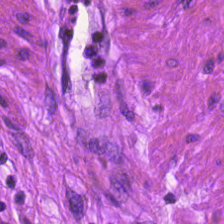

In [ ]:
d_train_tiny = Dataset('train_tiny') # Загружаем небольшой тренировочный набор


img, lbl = d_train_tiny.random_image_with_label() # Получаем случайное изображение и его метку
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [ ]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
class Metrics:
    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Основной класс, хранящий в себе всю информацию о модели.

Необходимо реализовать методы save, load для сохранения и заргрузки модели.

In [ ]:
class Model:

    def __init__(self, use_gpu=None, model_save_dir='/content/drive/MyDrive/'):
        # устройство
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") \
                      if use_gpu is None else torch.device("cuda" if use_gpu else "cpu")

        os.makedirs(model_save_dir, exist_ok=True)
        self.model_save_dir = model_save_dir

        # CNN DenseNet121 без классификатора
        self.cnn = models.densenet121(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = False
        self.cnn.classifier = torch.nn.Identity()
        self.cnn.to(self.device)
        self.cnn.eval()

        # SVM
        self.svm = SVC(kernel='linear', probability=True)
        self._is_trained = False
        self._last_train_meta = {}

    # извлечение признаков
    def extract_features(self, dataset):
        features, labels = [], []
        for img, lbl in zip(dataset.images, dataset.labels):
            x = torch.tensor(img.transpose(2,0,1), dtype=torch.float32).unsqueeze(0) / 255.
            x = x.to(self.device)
            with torch.no_grad():
                feat = self.cnn(x).cpu().numpy().squeeze()
            features.append(feat)
            labels.append(lbl)
        return np.array(features), np.array(labels)

    # обучение SVM с валидацией и автоподбором гиперпараметров
    def train(self, dataset, val_fraction=0.1, do_grid_search=True, grid_params={'C':[0.01,0.1,1]}, autosave_best_name=None):
        feats, labels = self.extract_features(dataset)

        # делим train/val
        X_train, X_val, y_train, y_val = train_test_split(feats, labels, test_size=val_fraction, random_state=42)
        print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")

        # GridSearchCV (автоподбор гиперпараметров)
        if do_grid_search:
            grid = GridSearchCV(SVC(kernel='linear', probability=True), grid_params, cv=5, verbose=1)
            grid.fit(X_train, y_train)
            self.svm = grid.best_estimator_
            print("Лучшие гиперпараметры C:", grid.best_params_['C'])
        else:
            self.svm.fit(X_train, y_train)

        # Валидация
        val_acc = self.svm.score(X_val, y_val)
        print("Validation accuracy:", val_acc)

        self._is_trained = True

        # Автосохранение модели
        if autosave_best_name:
            self.save(autosave_best_name)

    # предсказание для одного изображения
    def test_on_image(self, img):
        if not self._is_trained:
            raise RuntimeError("Модель не обучена!")
        x = torch.tensor(img.transpose(2,0,1), dtype=torch.float32).unsqueeze(0) / 255.
        x = x.to(self.device)
        with torch.no_grad():
            feat = self.cnn(x).cpu().numpy().squeeze()
        return int(self.svm.predict(feat.reshape(1, -1))[0])

    # предсказание для всего датасета
    def test_on_dataset(self, dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    # сохранение модели
    def save(self, name):
        path = os.path.join(self.model_save_dir, f"{name}.joblib")
        joblib.dump(
            {
                'svm': self.svm,
                'cnn_state': self.cnn.state_dict(),
                'meta': self._last_train_meta
            },
            path
        )
        print("Модель сохранена:", path)

    # словарь URL для загрузки моделей
    MODEL_URLS = {
        "best": "https://drive.google.com/uc?id=1U_mA_gHkpBUUjfrwDvEOAYj1iN83YWbN"
    }

    # загрузка модели
    def load(self, name, url=None):
        path = os.path.join(self.model_save_dir, f"{name}.joblib")

        # Если веса отсутствуют локально — скачиваем
        if not os.path.exists(path):
            if url is None:
                url = self.MODEL_URLS.get(name)
            if url is None:
                raise FileNotFoundError("Нет локального файла и нет URL для загрузки модели.")
            print(f"Скачиваю модель из Google Drive:\n{url}")
            gdown.download(url, path, fuzzy=True, quiet=False)

        # Загружаем веса
        data = joblib.load(path)
        self.svm = data["svm"]
        self.cnn.load_state_dict(data["cnn_state"])
        self.cnn.to(self.device)
        self.cnn.eval()

        self._last_train_meta = data.get("meta", {})
        self._is_trained = True
        print("Модель загружена:", path)

    # Матрица ошибок
    def save_confusion_matrix(self, gt, preds, classes=None, name="conf_matrix"):
        cm = confusion_matrix(gt, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel("Предсказание")
        plt.ylabel("Истинный класс")
        plt.title("Матрица ошибок")
        plt.show()
        return cm


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:30<00:00, 68.5MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:07<00:00, 74.3MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Начинаем обучение модели на полном наборе данных...
Training on 16200 samples, validating on 1800 samples.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшие гиперпараметры C: 0.1
Validation accuracy: 0.9622222222222222
Модель сохранена: /content/drive/MyDrive/best.joblib


100%|██████████| 4500/4500 [01:40<00:00, 44.78it/s]


metrics for CNN-features + SVM (full dataset):
	 accuracy 0.9571:
	 balanced accuracy 0.9571:


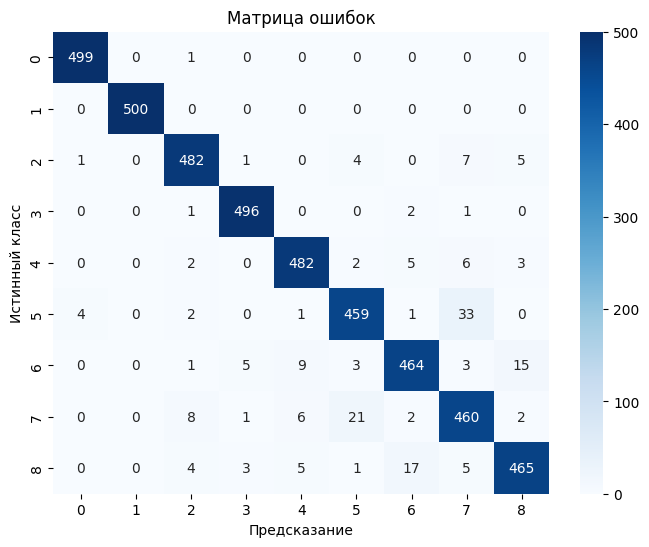

array([[499,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0, 482,   1,   0,   4,   0,   7,   5],
       [  0,   0,   1, 496,   0,   0,   2,   1,   0],
       [  0,   0,   2,   0, 482,   2,   5,   6,   3],
       [  4,   0,   2,   0,   1, 459,   1,  33,   0],
       [  0,   0,   1,   5,   9,   3, 464,   3,  15],
       [  0,   0,   8,   1,   6,  21,   2, 460,   2],
       [  0,   0,   4,   3,   5,   1,  17,   5, 465]])

In [ ]:
d_train = Dataset('train')
d_test = Dataset('test')

model = Model()

EVALUATE_ONLY = False

if not EVALUATE_ONLY:
    print("Начинаем обучение модели на полном наборе данных...")
    model.train(
        d_train,
        val_fraction=0.1,  # 10% данных для валидации
        do_grid_search=True,  # автоподбор C для SVM
        grid_params={'C':[0.01, 0.1, 1]},
        autosave_best_name='best'  # автосохранение
    )
else:
    # загружаем предобученную модель
    print("Загружаем предобученную модель...")
    model.load('best')

# предсказания на полном тестовом наборе
predictions = model.test_on_dataset(d_test)

# выводим метрики
Metrics.print_all(d_test.labels, predictions, info="CNN-features + SVM (full dataset)")

# строим матрицу ошибок
TISSUE_CLASSES = sorted(list(set(d_test.labels)))
model.save_confusion_matrix(gt=d_test.labels, preds=predictions, classes=TISSUE_CLASSES)


Тестирование на любых входных данных ( test 2, test 3)


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 120MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.0MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
Модель загружена: /content/drive/MyDrive/best.joblib


100%|██████████| 1800/1800 [00:40<00:00, 43.91it/s]


metrics for Results on test_2:
	 accuracy 0.9600:
	 balanced accuracy 0.9600:


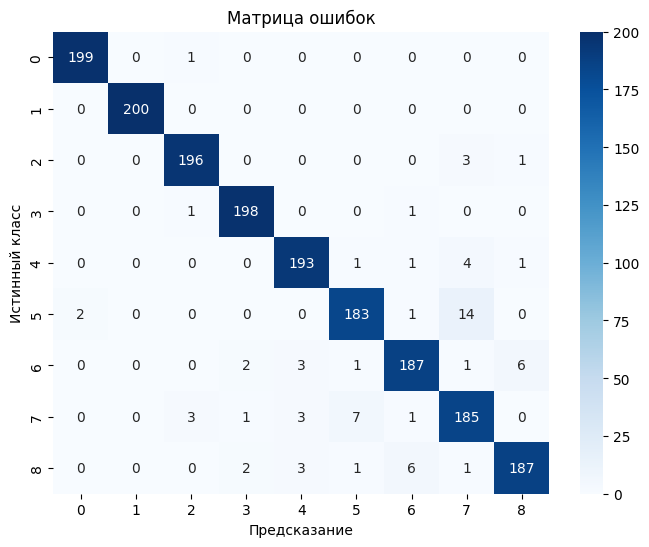

100%|██████████| 90/90 [00:01<00:00, 49.54it/s]


metrics for Results on test_3:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


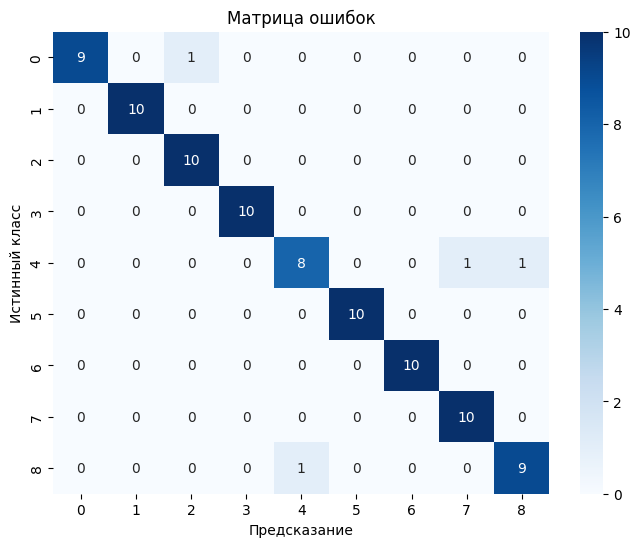

array([[ 9,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  0,  1,  1],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  9]])

In [ ]:

# Нужно заменить 'test_small' и 'test_tiny' на 'test_2' и 'test_3'

d_test_2 = Dataset("test_small")  # Пока проверяем на test_small
d_test_3 = Dataset("test_tiny")   # Пока проверяем на test_tiny

model = Model()
model.load("best")

# Проверка на test_2
preds_2 = model.test_on_dataset(d_test_2)
Metrics.print_all(d_test_2.labels, preds_2, "Results on test_2")

# Матрица ошибок для test_2
TISSUE_CLASSES_2 = sorted(list(set(d_test_2.labels)))
model.save_confusion_matrix(gt=d_test_2.labels, preds=preds_2, classes=TISSUE_CLASSES_2)

# Проверка на test_3
preds_3 = model.test_on_dataset(d_test_3)
Metrics.print_all(d_test_3.labels, preds_3, "Results on test_3")

# Матрица ошибок для test_3
TISSUE_CLASSES_3 = sorted(list(set(d_test_3.labels)))
model.save_confusion_matrix(gt=d_test_3.labels, preds=preds_3, classes=TISSUE_CLASSES_3)


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()